In [74]:
import simpy
import networkx as nx

import itertools
import requests
import pickle
import io


In [23]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [27]:
graph = pickle.load(io.BytesIO(resp.content))

In [55]:
n_hubs_source = 5
n_hubs_dest = 5

duration_spoke_hub = 1
duration_spoke = 2
capacity_hub = 1

capacity_bus = 1
duration_bus = 10


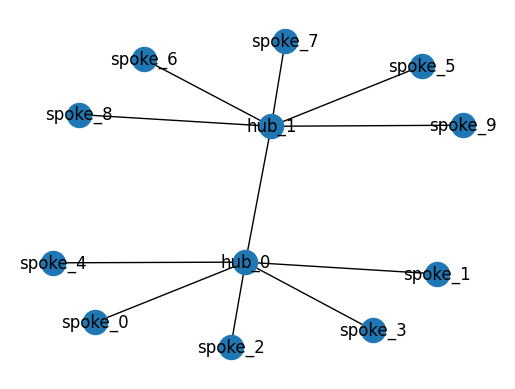

In [76]:
graph = nx.Graph()
hub_nodes = ["hub_0", "hub_1"]
for n in hub_nodes:
    graph.add_node(n)
graph.add_edge(hub_nodes[0], hub_nodes[1])

counter = itertools.count()
for i, n_id in zip(range(n_hubs_source), counter):
    n = f"spoke_{n_id}"
    graph.add_node(n)
    graph.add_edge(n, hub_nodes[0])
    
for i, n_id in zip(range(n_hubs_dest), counter):
    n = f"spoke_{n_id}"
    graph.add_node(n)
    graph.add_edge(hub_nodes[1], n)

pos = nx.spring_layout(graph)
nx.draw_networkx_labels(graph, pos=pos)
nx.draw(graph, pos=pos)
    

In [45]:
def transport_direct(env, a, b, fairway):
    print(f'claiming a at {env.now}')
    with a["resource"].request() as a_res_request:
        yield a_res_request
        yield a["container"].get(1)
        yield env.timeout(1)
    print(f'start sailing at {env.now}')
    with fairway.request() as fairway_request:
        yield fairway_request
        yield env.timeout(10)
    print(f'claiming b at {env.now}')
    with b["resource"].request() as b_res_request:
        yield b_res_request
        yield b["container"].get(1)
        yield env.timeout(1)
    print(f'done a at {env.now}')
    
def transport_hubs(env, a, b, fairway):
    print(f'claiming a at {env.now}')
    with a["resource"].request() as a_res_request:
        yield a_res_request
        yield a["container"].get(1)
        yield env.timeout(1)
    
    print(f'start sailing at {env.now}')
    with fairway.request() as fairway_request:
        yield fairway_request
        yield env.timeout(10)
    print(f'claiming b at {env.now}')
    with b["resource"].request() as b_res_request:
        yield b_res_request
        yield b["container"].get(1)
        yield env.timeout(1)
    print(f'done a at {env.now}')    
        
    

In [49]:
env = simpy.Environment()
fairway = simpy.Resource(env=env, capacity=3)

a = {"resource": simpy.Resource(env), "container": simpy.Container(env, capacity=100, init=100)}
b = {"resource": simpy.Resource(env), "container": simpy.Container(env, capacity=100, init=0)}
spokes = [a, b]
env.process(transport(env, a=a, b=b, fairway=fairway))
env.process(transport(env, a=a, b=b, fairway=fairway))
env.process(transport(env, a=a, b=b, fairway=fairway))
env.process(transport(env, a=a, b=b, fairway=fairway))
env.process(transport(env, a=a, b=b, fairway=fairway))
env.run()

claiming a at 0
claiming a at 0
claiming a at 0
claiming a at 0
claiming a at 0
start sailing at 1
start sailing at 2
start sailing at 3
start sailing at 4
start sailing at 5
claiming b at 11
claiming b at 12
claiming b at 13
claiming b at 21
claiming b at 22
